In [37]:
%load_ext rpy2.ipython
%pylab inline
import importlib
#from mdata.mdata import *
import mdata.mdata as mdata
importlib.reload(mdata)
%R require(ggplot2)
%R require(RColorBrewer)
from jupyterthemes import jtplot
jtplot.style()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
Populating the interactive namespace from numpy and matplotlib


In [250]:
%R nbtheme <- theme_classic() + theme(text=element_text(family="sans",size=8,colour="#EDEDED"), \
                                     plot.background=element_rect(fill="#384151",color="#384151"), \
                                     panel.background=element_rect(fill="#384151"), \
                                     strip.background=element_rect(fill="#384151"), \
                                     legend.background=element_rect(fill="#384151",colour="#616978"), \
                                     axis.line.x=element_line(colour="#899AB8"), \
                                     axis.line.y=element_line(colour="#899AB8"), \
                                     axis.ticks=element_line(colour=NA), \
                                     axis.text=element_text(colour="#EDEDED",size=8), \
                                     panel.grid.major=element_line(colour="#546379"), \
                                     panel.grid.minor=element_line(colour="#546379"), \
                                     legend.key=element_rect(colour="#384151",fill=NA), \
                                     plot.title=element_text(hjust = 0.5));
%R extheme <- theme_classic() + theme(text=element_text(family="sans",size=8), \
                                     axis.text=element_text(size=8), \
                                     legend.position='none');

In [145]:
importlib.reload(mdata)
l = mdata.Loader().useFile(mdata.CSV.LOD)
l.getColumn('markovBrainDeterministic*')
l.getColumn('score')
l.getColumn('update')
#l.sampleEvery(50)
l.load()
d = l.data

loading from cache


In [146]:
## rename columns
colmap = {
'conditionID':'NAME_HERE',
'markovBrainDeterministicGates':'Independent Bit',
'markovBrainDeterministicWithDirectGates':'Single Site',
'markovBrainDeterministicWithProbabilityGates':'Traditional',
'markovBrainGates':'NAME_HERE',
'repID':'NAME_HERE',
'score':'Fitness',
'update':'Generations'}
d.renameColumns(colmap)

## create new clean column for Task
wmap = {
'Berry':'Foraging',
'PathAssociation':'AssociativeMemory'}
d.mapConditionIDs(wmap,newColName='Task')

## create new clean column for GateType (condition)
cmap = {
'DEF_0__DWD_1__DWP_0':'Single Site',
'DEF_0__DWD_0__DWP_1':'Traditional',
'DEF_1__DWD_1__DWP_1':'All',
'DEF_1__DWD_0__DWP_0':'Independent Bit'}
d.mapConditionIDs(cmap,newColName='GateType')

## drop columns we don't care about anymore
d.dropColumns(['conditionID'])
## convert the gate counts from wide to long format (new col of which type, and new col of its count)
d.mergeColumns(['Independent Bit','Single Site','Traditional'],'GateCountType','GateCount')
## inspect results
d.head(3)

Fitness      Task  repID     GateType  Generations    GateCountType  \
0      1.0  Foraging    131  Traditional            0  Independent Bit   
1     37.0  Foraging    131  Traditional          100  Independent Bit   
2     33.0  Foraging    131  Traditional          200  Independent Bit   

   GateCount  
0          0  
1          0  
2          0

In [147]:
## make copy of data for all evolution-over-generations style plots
edata = d.copy()
## transform the data to its statistics (mean & CI)
edata.transformToMeanAndCI(columns=['Fitness','GateCount'],smoosh=['repID'])
## get raw dataframe in a single varname for push to R
redata = edata.dataframe
## inspect for sanity
redata.head()

Generations               Task    GateCountType         GateType  \
0            0  AssociativeMemory  Independent Bit              All   
1            0  AssociativeMemory  Independent Bit  Independent Bit   
2            0  AssociativeMemory  Independent Bit      Single Site   
3            0  AssociativeMemory  Independent Bit      Traditional   
4            0  AssociativeMemory      Single Site              All   

   mean.Fitness  mean.GateCount  upperCI.Fitness  upperCI.GateCount  \
0       76.8800          5.9325       104.477240           5.981849   
1       73.6125         17.7300        96.967989          17.789855   
2       69.2300          0.0000        88.419455           0.000000   
3       79.4975          0.0000       104.915800           0.000000   
4       76.8800          5.9425       104.477240           5.981650   

   lowerCI.Fitness  lowerCI.GateCount  
0        49.282760           5.883151  
1        50.257011          17.670145  
2        50.040545           0.000000  
3        54.079200           0.000000  
4        49.282760           5.903350

In [148]:
## make copy of data for all end-of-evolution GateCount style plots, averaging over all reps AND a few generations
cd = d.copy()
cd.dropColumns(['Fitness'])
cd.dataframe = cd.dataframe[(cd.dataframe['Generations']>=2700) & (cd.dataframe['Generations']<=2900)]
cd.transformToMeanAndCI(columns=['GateCount'],smoosh=['repID','Generations'])
rcoldata = cd.dataframe
rcoldata.head()

Task    GateCountType         GateType  mean.GateCount  \
0  AssociativeMemory  Independent Bit              All          1.3625   
1  AssociativeMemory  Independent Bit  Independent Bit          3.4825   
2  AssociativeMemory  Independent Bit      Single Site          0.0000   
3  AssociativeMemory  Independent Bit      Traditional          0.0000   
4  AssociativeMemory      Single Site              All          1.2825   

   upperCI.GateCount  lowerCI.GateCount  
0           1.446446           1.278554  
1           3.564748           3.400252  
2           0.000000           0.000000  
3           0.000000           0.000000  
4           1.362537           1.202463

In [149]:
## make copy of data for all end-of-evolution Fitness style plots, averaging over all reps AND a few generations
cd = d.copy()
cd.dropColumns(['GateCount','GateCountType'])
cd.dataframe = cd.dataframe[(cd.dataframe['Generations']>=2700) & (cd.dataframe['Generations']<=2900)]
cd.transformToMeanAndCI(columns=['Fitness'],smoosh=['repID','Generations'])
rfinaldata = cd.dataframe
rfinaldata.head()

Task         GateType  mean.Fitness  upperCI.Fitness  \
0  AssociativeMemory              All   3091.949167      3107.331005   
1  AssociativeMemory  Independent Bit   3107.888333      3121.729108   
2  AssociativeMemory      Single Site   3053.519167      3071.230959   
3  AssociativeMemory      Traditional   3083.205833      3098.851181   
4           Foraging              All     68.329667        68.903137   

   lowerCI.Fitness  
0      3076.567328  
1      3094.047559  
2      3035.807375  
3      3067.560486  
4        67.756196

/home/miniconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


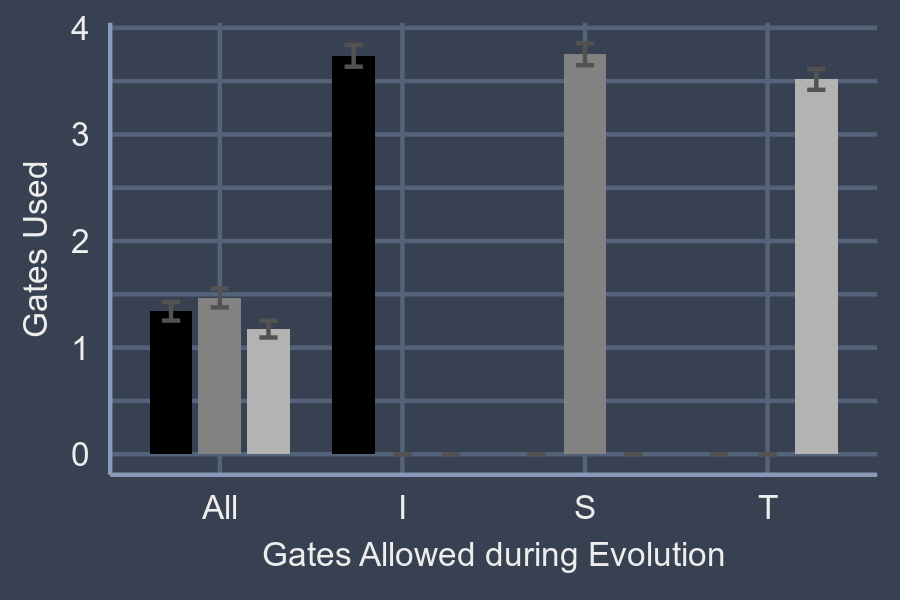

In [251]:
%%R -i rcoldata -u in -r 300 -w 3 -h 2
d = subset(rcoldata, Task=='Foraging')
g = ggplot(d,aes(x=GateType,y=mean.GateCount,ymin=lowerCI.GateCount,ymax=upperCI.GateCount,fill=GateCountType)) +
geom_bar(stat='identity', position=position_dodge(0.8), width=0.7) +
geom_errorbar(position=position_dodge(0.8), width=0.3, size=0.5, color='gray32') +
scale_fill_grey(start = 0.0, end = 0.7) +
scale_color_grey(start = 0.0, end = 0.7) +
scale_x_discrete(labels=c('All'='All','Independent Bit'='I','Single Site'='S','Traditional'='T'),
                limits=c('All','Independent Bit','Single Site','Traditional')) +
labs(fill='Gate Type',y='Gates Used',x='Gates Allowed during Evolution') +
guides(fill=F) +
nbtheme
print(g)
ggsave('fig_gate_count.pdf', plot=g+extheme, units='in', width=3, height=2, dpi=300)

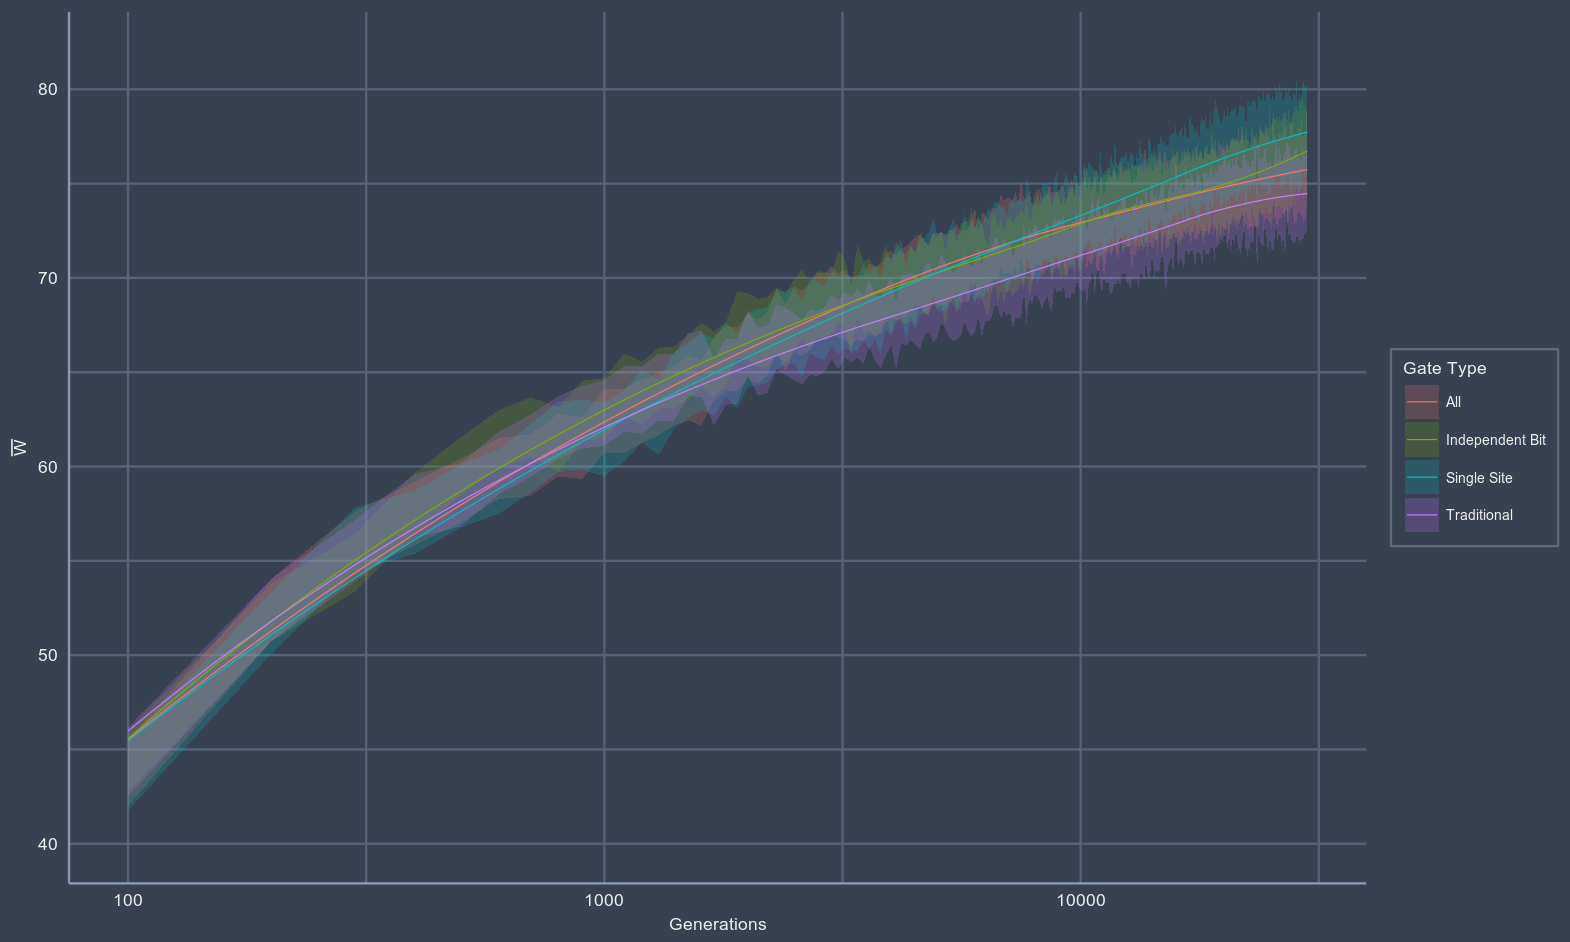

In [252]:
%%R -u in -r 157 -w 10 -h 6 -i redata
#data_foraging = subset(redata,(Task=='Foraging')&(GateType=='Single Site' | GateType=='Traditional'))
data_foraging = subset(redata,(Task=='Foraging'))
g = ggplot(data_foraging,aes(x=Generations,y=mean.Fitness,group=GateType,fill=GateType,color=GateType)) +
    geom_ribbon(aes(ymin=lowerCI.Fitness,ymax=upperCI.Fitness,fill=GateType),alpha=0.2,linetype='blank') +
    #geom_line() +
    geom_smooth(method='loess',se=0,size=0.25) +
    ylab(expression(bar('W'))) + labs(fill='Gate Type',color='Gate Type') +
    scale_x_log10() +
    ylim(40,82) +
    #guides(fill=F,color=F,group=F) +
    #labs(title='Evolution of Restricted Gate Use: Foraging Task') +
    nbtheme
print(g)
ggsave('fig_foraging_evolution.pdf', plot=g+extheme, units='in', width=3, height=2, dpi=300)

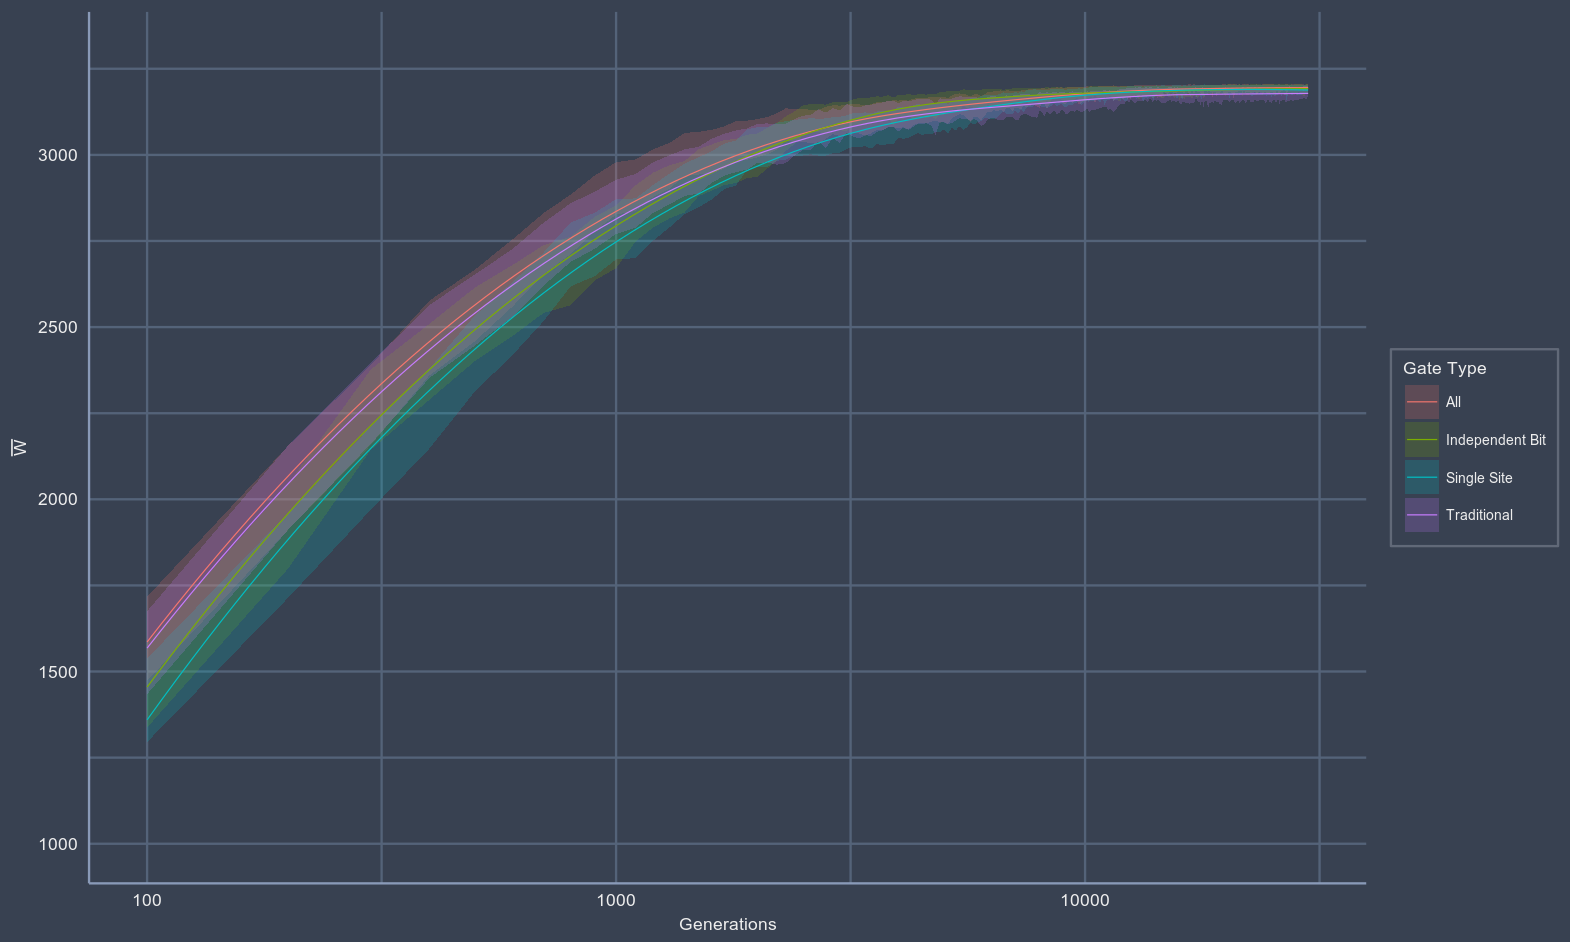

In [253]:
%%R -u in -r 157 -w 10 -h 6 -i redata
data_path = subset(redata,Task=='AssociativeMemory')
g<-ggplot(data_path,aes(x=Generations,y=mean.Fitness,group=GateType,color=GateType)) +
    geom_ribbon(aes(ymin=lowerCI.Fitness,ymax=upperCI.Fitness,fill=GateType),alpha=0.2,linetype='blank') +
    #geom_line() +
    geom_smooth(method='loess',se=0,size=0.25) +
    ylab(expression(bar('W'))) + labs(fill='Gate Type',color='Gate Type') +
    scale_x_log10() +
    ylim(1000,3300) +
    #guides(color=F,fill=F,group=F) +
    #labs(title='Evolution of Restricted Gate Use: Associative Task') +
    nbtheme
print(g)
ggsave('fig_associative_evolution.pdf', plot=g+extheme, units='in', width=3, height=2, dpi=300)

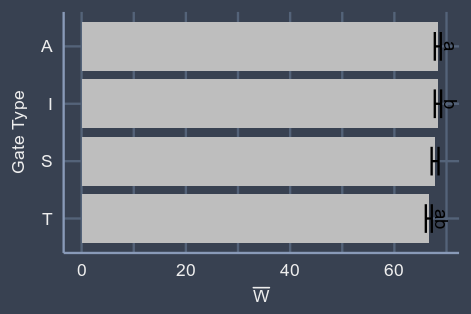

In [254]:
%%R -u in -r 157 -w 3 -h 2 -i rfinaldata
## Foraging END OF EVOLUTION
end_berry = subset(rfinaldata,Task=='Foraging')
g = ggplot(end_berry,aes(x=GateType,y=mean.Fitness,
                        ymin=lowerCI.Fitness,ymax=upperCI.Fitness)) +
geom_bar(stat='identity',width=0.85,fill='gray') +
geom_errorbar(width=0.5) +
ylab(expression(bar('W'))) +
labs(x='Gate Type',fill='Gate Type',color='Gate Type') + #,title='Final Fitness (Foraging)') +
scale_x_discrete(labels=c('Traditional'='T','Single Site'='S','Independent Bit'='I','All'='A'),
                 limits=c('Traditional','Single Site','Independent Bit','All')) +
coord_flip() +
geom_text(aes(label=c('a','b','','ab')),vjust=-0.5,angle=-90,size=3) +
nbtheme
print(g)
ggsave('fig_foraging_final.pdf', plot=g+extheme, units='in', width=3, height=2, dpi=300)

In [169]:
cd = d.copy()
cd.dataframe=cd.dataframe[cd.dataframe.Task == 'Foraging']
cd.dropColumns(['GateCount','GateCountType'])
cd.dataframe = cd.dataframe[(cd.dataframe['Generations']>=2700) & (cd.dataframe['Generations']<=2900)]
call = cd.dataframe[cd.dataframe.GateType == 'All'].Fitness.values
cind = cd.dataframe[cd.dataframe.GateType == 'Independent Bit'].Fitness.values
csin = cd.dataframe[cd.dataframe.GateType == 'Single Site'].Fitness.values
ctra = cd.dataframe[cd.dataframe.GateType == 'Traditional'].Fitness.values

allmeasures = [call,cind,csin,ctra]
measurenames={mean(call):'All',mean(cind):'Independent Bit',mean(csin):'Single Site',mean(ctra):'Traditional'}

from itertools import combinations
from scipy.stats import mannwhitneyu
combos = combinations(allmeasures,2)
ncombos = len(list(combinations(allmeasures,2)));
predetermined_p = 0.05
print("Mann-Whitney U P-values ('*' indicates < {0:.4f} significance)".format(predetermined_p/ncombos))
for measureA,measureB in combos:
    u,p=mannwhitneyu(measureA,measureB)
    significance_str = '{0:.7f}'.format(p)
    if (p < predetermined_p/ncombos):
        significance_str += " *"
    print(measurenames[mean(measureA)] + ' and ' + measurenames[mean(measureB)] + ': ' + significance_str)

Mann-Whitney U P-values ('*' indicates < 0.0083 significance)
All and Independent Bit: 0.4084586
All and Single Site: 0.2157725
All and Traditional: 0.0019516 *
Independent Bit and Single Site: 0.1724223
Independent Bit and Traditional: 0.0007804 *
Single Site and Traditional: 0.0232385


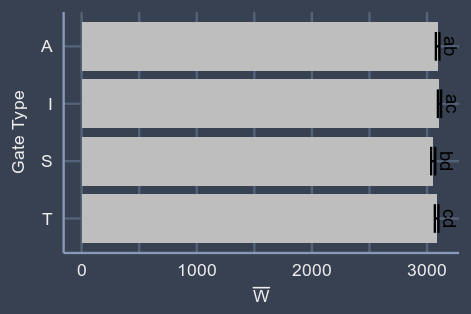

In [255]:
%%R -u in -r 157 -w 3 -h 2 -i rfinaldata
## Associative Memory END OF EVOLUTION
end_path = subset(rfinaldata,Task=='AssociativeMemory')
g<-ggplot(end_path,aes(x=GateType,y=mean.Fitness)) +
geom_bar(stat='identity',width=0.85,fill='gray') +
geom_errorbar(aes(x=GateType,ymin=lowerCI.Fitness,ymax=upperCI.Fitness),width=0.5) +
ylab(expression(bar('W'))) +
labs(x='Gate Type',fill='Gate Type',color='Gate Type') + #,title='Final Fitness (Associative Memory)') +
scale_x_discrete(labels=c('Traditional'='T','Single Site'='S','Independent Bit'='I','All'='A'),
                 limits=c('Traditional','Single Site','Independent Bit','All')) +
coord_flip() +
geom_text(aes(label=c('ab','ac','bd','cd')),vjust=-0.5,angle=-90,size=3) +
nbtheme
print(g)
ggsave('fig_associative_final.pdf', plot=g+extheme, units='in', width=3, height=2, dpi=300)

In [166]:
cd = d.copy()
cd.dataframe=cd.dataframe[cd.dataframe.Task == 'AssociativeMemory']
cd.dropColumns(['GateCount','GateCountType'])
cd.dataframe = cd.dataframe[(cd.dataframe['Generations']>=2700) & (cd.dataframe['Generations']<=2900)]
call = cd.dataframe[cd.dataframe.GateType == 'All'].Fitness.values
cind = cd.dataframe[cd.dataframe.GateType == 'Independent Bit'].Fitness.values
csin = cd.dataframe[cd.dataframe.GateType == 'Single Site'].Fitness.values
ctra = cd.dataframe[cd.dataframe.GateType == 'Traditional'].Fitness.values

allmeasures = [call,cind,csin,ctra]
measurenames={mean(call):'All',mean(cind):'Independent Bit',mean(csin):'Single Site',mean(ctra):'Traditional'}

from itertools import combinations
from scipy.stats import mannwhitneyu
combos = combinations(allmeasures,2)
ncombos = len(list(combinations(allmeasures,2)));
predetermined_p = 0.05
print("Mann-Whitney U P-values ('*' indicates < {0:.4f} significance)".format(predetermined_p/ncombos))
for measureA,measureB in combos:
    u,p=mannwhitneyu(measureA,measureB)
    significance_str = '{0:.7f}'.format(p)
    if (p < predetermined_p/ncombos):
        significance_str += " *"
    print(measurenames[mean(measureA)] + ' and ' + measurenames[mean(measureB)] + ': ' + significance_str)

Mann-Whitney U P-values ('*' indicates < 0.0083 significance)
All and Independent Bit: 0.0002375 *
All and Single Site: 0.0021820 *
All and Traditional: 0.4734741
Independent Bit and Single Site: 0.3144358
Independent Bit and Traditional: 0.0002360 *
Single Site and Traditional: 0.0019918 *


In [183]:
cd = d.copy()
cd.dropColumns(['GateCount','GateCountType'])
cd.dataframe = cd.dataframe[cd.dataframe['Generations']==5000]
cd.transformToMeanAndCI(columns=['Fitness'],smoosh=['repID'])
rearlydata = cd.dataframe

In [181]:
%%R -u in -r 157 -w 3 -h 2 -i rearlydata
## Associative Memory EARLY EVOLUTION
early_path = subset(rfinaldata,Task=='AssociativeMemory')
g<-ggplot(early_path,aes(x=GateType,y=mean.Fitness)) +
geom_bar(stat='identity',width=0.85,fill='gray') +
geom_errorbar(aes(x=GateType,ymin=lowerCI.Fitness,ymax=upperCI.Fitness),width=0.5) +
ylab(expression(bar('W'))) +
labs(x='Gate Type',fill='Gate Type',color='Gate Type') + #,title='Final Fitness (Associative Memory)') +
scale_x_discrete(labels=c('Traditional'='T','Single Site'='S','Independent Bit'='I','All'='A'),
                 limits=c('Traditional','Single Site','Independent Bit','All')) +
coord_flip() +
nbtheme
print(g)
ggsave('fig_associative_early.pdf', plot=g+extheme, units='in', width=3, height=2, dpi=300)

In [191]:
cd = d.copy()
cd.dropColumns(['GateCount','GateCountType'])
cd.dataframe = cd.dataframe[cd.dataframe['Generations']==2400]
cd.dataframe = cd.dataframe[cd.dataframe['Task']=='AssociativeMemory']

call = cd.dataframe[cd.dataframe.GateType == 'All'].Fitness.values
cind = cd.dataframe[cd.dataframe.GateType == 'Independent Bit'].Fitness.values
csin = cd.dataframe[cd.dataframe.GateType == 'Single Site'].Fitness.values
ctra = cd.dataframe[cd.dataframe.GateType == 'Traditional'].Fitness.values

allmeasures = [call,cind,csin,ctra]
measurenames={mean(call):'All',mean(cind):'Independent Bit',mean(csin):'Single Site',mean(ctra):'Traditional'}

from itertools import combinations
from scipy.stats import mannwhitneyu
combos = combinations(allmeasures,2)
ncombos = len(list(combinations(allmeasures,2)));
predetermined_p = 0.05
print("Mann-Whitney U P-values ('*' indicates < {0:.4f} significance)".format(predetermined_p/ncombos))
for measureA,measureB in combos:
    u,p=mannwhitneyu(measureA,measureB)
    significance_str = '{0:.7f}'.format(p)
    if (p < predetermined_p/ncombos):
        significance_str += " *"
    print(measurenames[mean(measureA)] + ' and ' + measurenames[mean(measureB)] + ': ' + significance_str)

Mann-Whitney U P-values ('*' indicates < 0.0083 significance)
All and Independent Bit: 0.0164670
All and Single Site: 0.2482558
All and Traditional: 0.1831479
Independent Bit and Single Site: 0.0734105
Independent Bit and Traditional: 0.0012157 *
Single Site and Traditional: 0.0467275


In [205]:
## comparison of std dev of all condition data at t=early and t=late in evolution
print('Foraging std dev comparison')
cd = d.copy()
cd.dropColumns(['GateCount','GateCountType'])
cd.dataframe = cd.dataframe[cd.dataframe['Generations']==5000]
print('std dev at t=5000: {:.2f}'.format(numpy.std(cd.dataframe[cd.dataframe['Task']=='Foraging']['Fitness'])))

cd = d.copy()
cd.dropColumns(['GateCount','GateCountType'])
cd.dataframe = cd.dataframe[cd.dataframe['Generations']==29000]
print('std dev at 27000 <= t <= 29000: {:.2f}'.format(numpy.std(cd.dataframe[cd.dataframe['Task']=='Foraging']['Fitness'])))

Foraging std dev comparison
std dev at t=5000: 19.64
std dev at 27000 <= t <= 29000: 22.52


In [206]:
## comparison of std dev of all condition data at t=early and t=late in evolution
print('Associative Memory std dev comparison')
cd = d.copy()
cd.dropColumns(['GateCount','GateCountType'])
cd.dataframe = cd.dataframe[cd.dataframe['Generations']==5000]
print('std dev at t=5000: {:.2f}'.format(numpy.std(cd.dataframe[cd.dataframe['Task']=='AssociativeMemory']['Fitness'])))

cd = d.copy()
cd.dropColumns(['GateCount','GateCountType'])
cd.dataframe = cd.dataframe[cd.dataframe['Generations']==29000]
print('std dev at 27000 <= t <= 29000: {:.2f}'.format(numpy.std(cd.dataframe[cd.dataframe['Task']=='AssociativeMemory']['Fitness'])))

Associative Memory std dev comparison
std dev at t=5000: 365.07
std dev at 27000 <= t <= 29000: 141.04
